In [133]:
# Imports
from strategy.actions import random_action
from data.fetch_data import fetch_data
from data.process_data import calculate_returns
from visualizations.plot_results import plot_net_worth, plot_cash, plot_portfolio_value, plot_rewards
from simulations.run_simulation import run_simulation

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [31]:
tickers = ['AAPL', 'KO', 'IBM']
start_date = "2010-01-01"
end_date = "2017-12-31"

data = fetch_data(tickers, start_date, end_date)
rets = calculate_returns(data)
data

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,IBM,KO
Date,,,
2010-01-01,6.351058,73.703934,17.938570
2010-01-08,6.316374,75.274139,18.238665
2010-01-15,6.275355,73.390991,17.357544
2010-01-22,6.010552,70.404167,17.296885
2010-01-29,5.792195,69.977478,17.057447
...,...,...,...
2017-12-01,39.876526,107.056381,37.264786
2017-12-08,40.559509,107.356133,37.468292
2017-12-15,41.216583,105.613365,37.118263


In [85]:
np.random.seed(123)

mapper = {'AAPL': [rets['AAPL'].values, data['AAPL'].values[0], 0, 75], 
            'KO': [rets['KO'].values, data['KO'].values[0], 0, 75],
            'IBM': [rets['IBM'].values, data['IBM'].values[0], 10, 1150]}

initial_price_map = {'AAPL': data['AAPL'].values[0], 
            'KO': data['KO'].values[0],
            'IBM': data['IBM'].values[0]}

paths = {'AAPL': [], 'KO': [], 'IBM': []}
raw_paths = {'AAPL': [], 'KO': [], 'IBM': []}

for tick in tickers:
    emp_dist = mapper[tick][0]

    for i in range(10000):
        ret_path = np.random.choice(emp_dist, size=len(emp_dist), replace=True)
        raw_path = mapper[tick][1] * (1 + ret_path).cumprod()
        raw_paths[tick].append(raw_path)


In [90]:
# Initialize the Q-table
Q_table = np.zeros((64, 27, 27)) 
Q_table

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [168]:
def discretize_rets(rets, n_states=4, min_ret=-0.11, max_ret=0.14):
    return np.clip(np.floor((rets - min_ret) / (max_ret - min_ret) * n_states), 0, n_states - 1).astype(int) + 1

In [128]:
def map_ret_state_to_real(ret_state):
    real = ((ret_state[0] - 1) * 16) + ((ret_state[1] - 1) * 4) + (ret_state[2] - 1)
    return real

def map_pos_state_to_real(pos_state):
    real = ((pos_state[0] - 1) * 9) + ((pos_state[1] - 1) * 3) + (pos_state[2] - 1)
    return real

def map_real_to_pos_state(real_number):
    # Convert the real number to base-3 (get three digits)
    d1 = real_number // 9   # Corresponds to the first die
    d2 = (real_number % 9) // 3   # Corresponds to the second die
    d3 = real_number % 3   # Corresponds to the third die

    # Map base-3 digits (0, 1, 2) back to dice values (1, 2, 3)
    return np.array([d1 + 1, d2 + 1, d3 + 1])


In [169]:
def update_holdings(positions):
    holdings = np.array([2, 2, 2])
    for i, v in enumerate(positions.values()):
            pos = 0
            if v < 0:
                pos = 1
            elif v == 0:
                pos = 2
            else:
                pos = 3
            holdings[i] = pos
    return holdings

def calculate_final_reward(positions, stock_prices):
    final_reward = (positions['AAPL'] * stock_prices['AAPL'].iloc[-1]) + (positions['IBM'] * stock_prices['IBM'].iloc[-1]) + (positions['KO'] * stock_prices['KO'].iloc[-1])
    return final_reward

def evaluate_continuation(cash, positions, stock_prices, time):
    port_value = (positions['AAPL'] * stock_prices['AAPL'].iloc[time]) + (positions['IBM'] * stock_prices['IBM'].iloc[time]) + (positions['KO'] * stock_prices['KO'].iloc[time])
    net_worth = cash + port_value
    if net_worth < 0:
        return False
    else:
        return True

In [170]:
def labeled_actions_to_action_state(labeled_actions):
    sorted_list = sorted(labeled_actions, key=lambda x: x[1])
    legal_action_list = [v[0] for v in sorted_list]
    legal_action = np.array(legal_action_list)
    return legal_action

In [215]:
# Q-learning Algorithm Implementation
n_episodes = 10000
n_steps = 417
alpha = 0.1
epsilon = 0.1
gamma = 1
Q_table = np.zeros((64, 27, 27))
tickers = ['AAPL', 'KO', 'IBM']


for episode in range(n_episodes):
    cash = 100
    # Use a new stock price series for each episode
    stock_prices = pd.DataFrame({'AAPL': raw_paths['AAPL'][episode], 'IBM': raw_paths['IBM'][episode], 'KO': raw_paths['KO'][episode]})
    stock_returns = stock_prices.pct_change()

    # Initialize holdings to zero and a random state for the prior return
    raw_holdings = {'AAPL': 0, 'IBM': 0, 'KO': 0} 
    transaction_log = {'AAPL': {1: [], 3: []}, 'IBM': {1: [], 3: []}, 'KO': {1: [], 3: []}}
    holdings = np.array([2, 2, 2])
    returns = np.random.choice([1, 2, 3, 4], 3)
    return_state = map_ret_state_to_real(returns)
    holdings_state = map_pos_state_to_real(holdings)
    
    for t in range(n_steps - 1):
        if not evaluate_continuation(cash, raw_holdings, stock_prices, t):
            break
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.choice([1, 2, 3], 3)
        else:
            action = np.argmax(Q_table[return_state, holdings_state])
            action = map_real_to_pos_state(action)
        
        next_return_state = discretize_rets(stock_returns.iloc[t + 1, :])
        next_return_state = map_ret_state_to_real(next_return_state)

        reward = 0

        # Sort actions so that we evaluate sell orders first in order to fund potential buys
        labeled_actions = []
        for i in zip(action, tickers):
            labeled_actions.append(list(i))
        labeled_actions.sort(key=lambda x: x[0])
        
        for i in range(3):
            if labeled_actions[i][0] == 3:  # Buy
                if cash - stock_prices[labeled_actions[i][1]][t] > 0:  # Can only buy if have enough cash
                    if transaction_log[labeled_actions[i][1]][1]:
                        reward += transaction_log[labeled_actions[i][1]][1][0] - stock_prices[labeled_actions[i][1]][t]
                        transaction_log[labeled_actions[i][1]][1].pop(0)

                    else:
                        transaction_log[labeled_actions[i][1]][3].append(stock_prices[labeled_actions[i][1]][t])

                    cash -= stock_prices[labeled_actions[i][1]][t]
                    raw_holdings[labeled_actions[i][1]] += 1

                else: # If not enough cash to buy, then hold
                    labeled_actions[i][0] = 2

            elif labeled_actions[i][0] == 2: # Hold
                pass

            elif labeled_actions[i][0] == 1:  # Sell
                if transaction_log[labeled_actions[i][1]][3]:
                        reward += stock_prices[labeled_actions[i][1]][t] - transaction_log[labeled_actions[i][1]][3][0]
                        transaction_log[labeled_actions[i][1]][3].pop(0)
                else:
                    transaction_log[labeled_actions[i][1]][1].append(stock_prices[labeled_actions[i][1]][t])

                cash += stock_prices[labeled_actions[i][1]][t]
                raw_holdings[labeled_actions[i][1]] -= 1
        
        action = labeled_actions_to_action_state(labeled_actions)
        action_state = map_pos_state_to_real(action)
        next_holdings = update_holdings(raw_holdings)
        next_holdings_state = map_pos_state_to_real(next_holdings)
        
        # Q-learning update
        Q_table[return_state, holdings_state, action_state] += alpha * (reward + gamma * np.max(Q_table[next_return_state, next_holdings_state]) - Q_table[return_state, holdings_state, action_state])

        # Transition to next state
        holdings = next_holdings
        holdings_state = next_holdings_state
        return_state = next_return_state

    final_reward = calculate_final_reward(raw_holdings, stock_prices)
    Q_table[return_state, holdings_state, action_state] += final_reward

optimal_policy = np.argmax(Q_table, axis=2)


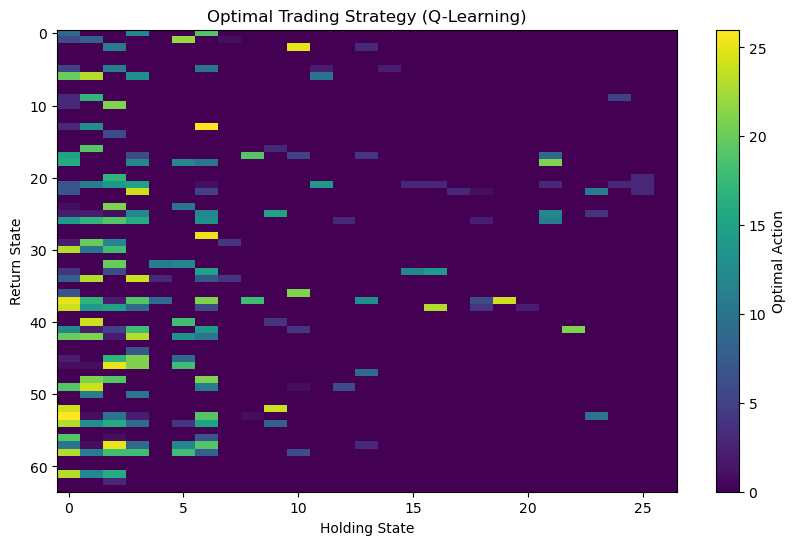

In [216]:
# Visualization of the optimal policy
plt.figure(figsize=(10, 6))
plt.imshow(optimal_policy, cmap="viridis", aspect="auto")
plt.colorbar(label="Optimal Action")
plt.xlabel("Holding State")
plt.ylabel("Return State")
plt.title("Optimal Trading Strategy (Q-Learning)")
plt.show()

# Visualization of the Q-values
# plt.figure(figsize=(10, 6))
# for holding in range(27):
#    for action in range(27):
#        plt.plot(Q_table[:, holding, action], label=f"Action {action} (Holding={holding})")
# plt.xlabel("Stock Price State")
# plt.ylabel("Q-Value")
# plt.title("Q-Values for Different Actions and Holding States")
# plt.legend()
# plt.grid(True)
# plt.show()


In [219]:
optimal_policy[1][0]

6

In [218]:
Q_table[1, 0, :]

array([ 13.05843602,  16.37338741, 207.32671061,  10.25013662,
        12.09016652,  18.39672503, 207.93322676,   0.        ,
         7.11183077,   4.07871952,   8.92659509,  26.02333228,
         0.        ,  29.26790711,  22.33349364,  10.8035812 ,
        44.6646351 ,  17.9858048 ,   4.47661473,  12.48497437,
        49.39550558,  62.85852304,  21.282743  ,  25.47181665,
        26.82802914,  19.08736237,  19.81775327])

## Evaluate Policy

In [220]:
tickers = ['AAPL', 'KO', 'IBM']
start_date = "2017-12-24"
end_date = "2018-12-31"

test_data_prices = fetch_data(tickers, start_date, end_date)
test_data_rets = test_data_prices.pct_change()

test_data_prices = test_data_prices.iloc[1:, :]
test_data_rets = test_data_rets.iloc[1:, :]
test_data_rets.head(5)

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,IBM,KO
Date,,,
2018-01-01,0.034096,0.059119,0.004141
2018-01-08,0.011943,0.004001,0.001736
2018-01-15,0.007736,-0.004720,0.021885
2018-01-22,-0.038945,0.030609,0.029050
2018-01-29,-0.064194,-0.049659,-0.037090


In [221]:
tracker = {}
cash = 100
holdings = np.array([2, 2, 2])
tickers = ['AAPL', 'IBM', 'KO']
raw_holdings = {'AAPL': 0, 'IBM': 0, 'KO': 0} 

for t in range(len(test_data_prices)):
    if not evaluate_continuation(cash, raw_holdings, test_data_prices, t):
            break
    
    prior_returns = discretize_rets(test_data_rets.iloc[t, :])
    return_state = map_ret_state_to_real(prior_returns)
    holdings_state = map_pos_state_to_real(holdings)

    action = map_real_to_pos_state(optimal_policy[return_state][holdings_state])

    # Sort actions so that we evaluate sell orders first in order to fund potential buys
    labeled_actions = []
    for i in zip(action, tickers):
        labeled_actions.append(list(i))
    labeled_actions.sort(key=lambda x: x[0])
        
    for i in range(3):
        if labeled_actions[i][0] == 3:  # Buy
            if cash - test_data_prices[labeled_actions[i][1]][t] > 0:  # Can only buy if have enough cash
                cash -= test_data_prices[labeled_actions[i][1]][t]
                raw_holdings[labeled_actions[i][1]] += 1

            else: # If not enough cash to buy, then hold
                labeled_actions[i][0] = 2

        elif labeled_actions[i][0] == 2: # Hold
            pass

        elif labeled_actions[i][0] == 1:  # Sell
            cash += test_data_prices[labeled_actions[i][1]][t]
            raw_holdings[labeled_actions[i][1]] -= 1
    
    port_value = (raw_holdings['AAPL'] * test_data_prices['AAPL'].iloc[t]) + (raw_holdings['IBM'] * test_data_prices['IBM'].iloc[t]) + (raw_holdings['KO'] * test_data_prices['KO'].iloc[t])
    net_worth = cash + port_value
    tracker[t] = (cash, port_value, net_worth, action)


In [222]:
tracker

{0: (291.98975372314453,
  -191.98975372314453,
  100.0,
  array([1, 1, 1], dtype=int64)),
 1: (484.9900131225586,
  -386.0005187988281,
  98.98949432373047,
  array([1, 1, 1], dtype=int64)),
 2: (678.5982437133789,
  -580.8246917724609,
  97.77355194091797,
  array([1, 1, 1], dtype=int64)),
 3: (875.1495094299316,
  -786.2050628662109,
  88.9444465637207,
  array([1, 1, 1], dtype=int64)),
 4: (1061.8495903015137,
  -933.5004043579102,
  128.34918594360352,
  array([1, 1, 1], dtype=int64)),
 5: (1238.0194816589355,
  -1057.0193481445312,
  181.0001335144043,
  array([1, 1, 1], dtype=int64)),
 6: (1425.3554420471191,
  -1311.3517227172852,
  114.00371932983398,
  array([1, 1, 1], dtype=int64)),
 7: (1425.3554420471191,
  -1307.8250198364258,
  117.53042221069336,
  array([2, 2, 2], dtype=int64)),
 8: (1611.3698844909668,
  -1488.1155395507812,
  123.25434494018555,
  array([1, 1, 1], dtype=int64)),
 9: (1802.5643997192383,
  -1720.7506370544434,
  81.81376266479492,
  array([1, 1, 1], d

## Changing the Reward Mechanism to Be Change in Net Worth

In [ ]:
# Q-learning Algorithm Implementation
n_episodes = 10000
n_steps = 417
alpha = 0.1
epsilon = 0.1
gamma = 1
Q_table = np.zeros((64, 27, 27))
tickers = ['AAPL', 'KO', 'IBM']


for episode in range(n_episodes):
    cash = 100
    # Use a new stock price series for each episode
    stock_prices = pd.DataFrame({'AAPL': raw_paths['AAPL'][episode], 'IBM': raw_paths['IBM'][episode], 'KO': raw_paths['KO'][episode]})
    stock_returns = stock_prices.pct_change()

    # Initialize holdings to zero and a random state for the prior return
    raw_holdings = {'AAPL': 0, 'IBM': 0, 'KO': 0} 
    holdings = np.array([2, 2, 2])
    returns = np.random.choice([1, 2, 3, 4], 3)
    return_state = map_ret_state_to_real(returns)
    holdings_state = map_pos_state_to_real(holdings)
    
    for t in range(n_steps - 1):
        if not evaluate_continuation(cash, raw_holdings, stock_prices, t):
            break
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.choice([1, 2, 3], 3)
        else:
            action = np.argmax(Q_table[return_state, holdings_state])
            action = map_real_to_pos_state(action)
        
        next_return_state = discretize_rets(stock_returns.iloc[t + 1, :])
        next_return_state = map_ret_state_to_real(next_return_state)

        reward = 0

        # Sort actions so that we evaluate sell orders first in order to fund potential buys
        labeled_actions = []
        for i in zip(action, tickers):
            labeled_actions.append(list(i))
        labeled_actions.sort(key=lambda x: x[0])
        
        for i in range(3):
            if labeled_actions[i][0] == 3:  # Buy
                if cash - stock_prices[labeled_actions[i][1]][t] > 0:  # Can only buy if have enough cash
                    reward -= stock_prices[labeled_actions[i][1]][t]
                    cash -= stock_prices[labeled_actions[i][1]][t]
                    raw_holdings[labeled_actions[i][1]] += 1

                else: # If not enough cash to buy, then hold
                    labeled_actions[i][0] = 2

            elif labeled_actions[i][0] == 2: # Hold
                pass

            elif labeled_actions[i][0] == 1:  # Sell
                reward += stock_prices[labeled_actions[i][1]][t]
                cash += stock_prices[labeled_actions[i][1]][t]
                raw_holdings[labeled_actions[i][1]] -= 1
        
        action = labeled_actions_to_action_state(labeled_actions)
        action_state = map_pos_state_to_real(action)
        next_holdings = update_holdings(raw_holdings)
        next_holdings_state = map_pos_state_to_real(next_holdings)
        
        # Q-learning update
        Q_table[return_state, holdings_state, action_state] += alpha * (reward + gamma * np.max(Q_table[next_return_state, next_holdings_state]) - Q_table[return_state, holdings_state, action_state])

        # Transition to next state
        holdings = next_holdings
        holdings_state = next_holdings_state
        return_state = next_return_state

    final_reward = calculate_final_reward(raw_holdings, stock_prices)
    Q_table[return_state, holdings_state, action_state] += final_reward

optimal_policy = np.argmax(Q_table, axis=2)
